In [1]:
import numpy as np
from keras.models import load_model

import load_data as ld

# Useful functions

In [2]:
def split_windows(arr, arr_ecg, gt, gt_bb, window_size):
    windows_list=[]
    windows_ecg_list=[]
    label_list=[]
    label_list_bb=[]

    index=0
    while index < len(arr)-window_size:
        windows_list.append(arr[index:index+window_size])
        windows_ecg_list.append(arr_ecg[index:index+window_size])
        label_list.append(gt[index:index+window_size])
        label_list_bb.append(gt_bb[index:index+window_size])
        index+=window_size
        index += 1

    return np.array(windows_list), np.array(windows_ecg_list), np.array(label_list), np.array(label_list_bb)

In [3]:
import skimage.morphology as sk

def threshold_pred(pred, thresh):
    pred_thresh=np.zeros(len(pred))

    for i in range(len(pred)):
        if(pred[i]>thresh):
            pred_thresh[i]=1

    return pred_thresh

def find_rising_edges(binary):

    train_grad=np.gradient(binary)
    train_grad_pos=np.where(train_grad>0)

    train_grad_pos_correct=[]
    for i in range(0, len(train_grad_pos[0]), 2):
        train_grad_pos_correct.append(train_grad_pos[0][i])

    return train_grad_pos_correct

def validation(pred_new, pred_grad_pos, gt):
    tp=0
    fp=0
    fn=0

    for ao_peak in gt:
        if(pred_new[int(ao_peak)]==1):
            tp+=1
        else:
            fn+=1

    fp=len(pred_grad_pos)-tp
       
    return tp, fp, fn 

def results(pred, gt, gt_mask=None, thresh=0.5, area_open=5):

    pred = np.asarray(pred)
    pred_bin = threshold_pred(pred, thresh)
    pred_open = sk.area_opening(pred_bin, area_open)
    pred_peaks = find_rising_edges(pred_open)
    tp, fp, fn = validation(pred_open, pred_peaks, gt)

    return pred_open, tp, fp, fn

In [4]:
def evaluate_pred(pred_subj, test_y_subj, y_test_mask_peaks):

    threshold=0.5
    area_op_size=5

    AO_ecg_subj=np.argwhere(y_test_mask_peaks==1) 

    pred_open, tp, fp, fn= results(pred_subj, AO_ecg_subj[:-10], test_y_subj, threshold, area_op_size)
    prec=tp/(tp+fp)
    recall=tp/(tp+fn)
    f1=2*tp/(2*tp +fp +fn)

    return pred_open, tp, fp, fn, prec, recall, f1

# Load and split data to evaluate

In [19]:
ECG_subjects, SCG_subjects, gt_boxes_AO_subj, ao_mask_peaks = ld.load_dataset("MEC")

#Change loading the desired signals to evaluate

In [20]:
#split signal in portions of window_size

window_size=6400 #dimension of window for evaluation (multiple of 64)
x_test_shuffle, wind_ecg, y_binary_mask_test_shuffle, y_binary_test_shuffle=split_windows(SCG_subjects[0], ECG_subjects[0], ao_mask_peaks[0], gt_boxes_AO_subj[0], window_size)

# Load saved model

In [24]:
# load model
model_path = 'saved_models/modelCEBS'
model=load_model(model_path)

# Predict and plot examples

In [25]:
pred_test=model.predict(x_test_shuffle[:, :, 2])

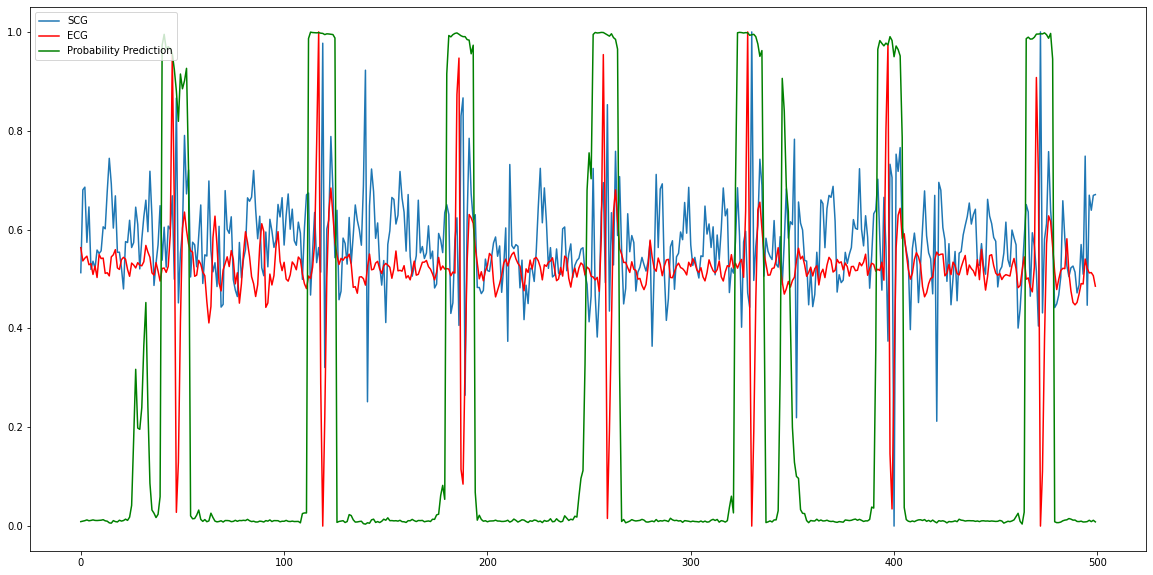

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(x_test_shuffle[0][500:1000, 2], label='SCG')
plt.plot(wind_ecg[0][500:1000], color='red', label='ECG') # not used in the prediction
plt.plot(pred_test[0][500:1000, 0], color='green', label='Probability Prediction')
plt.legend()

In [11]:
pred_open, tp, fp, fn, prec, recall, f1=evaluate_pred(pred_test[0], y_binary_test_shuffle[0], y_binary_mask_test_shuffle[0])

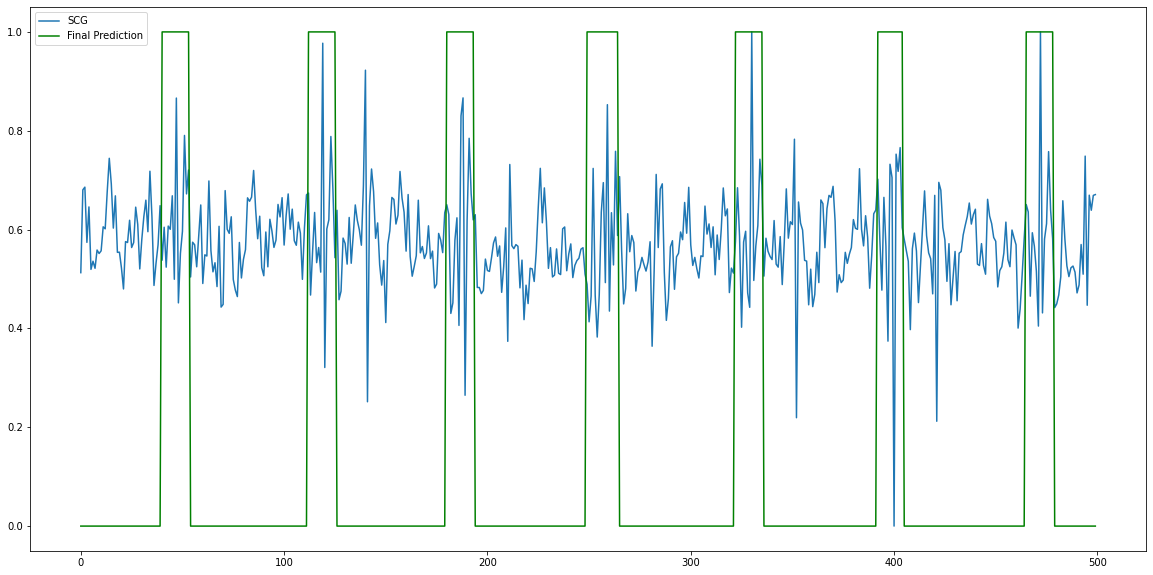

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(x_test_shuffle[0][500:1000, 2], label='SCG')
plt.plot(pred_open[500:1000], color='green', label='Final Prediction')
plt.legend()

# Evaluate predictions

In [13]:
pred_open_subj=[]
f1_subj=[]
prec_subj=[]
rec_subj=[]

for i in range(len(x_test_shuffle)):
    pred_open, tp, fp, fn, prec, recall, f1=evaluate_pred(pred_test[i], y_binary_test_shuffle[i], y_binary_mask_test_shuffle[i])
    pred_open_subj.append(pred_open)
    f1_subj.append(f1)
    prec_subj.append(prec)
    rec_subj.append(recall)

In [14]:
print("Evaluation on original model")
print("Precision:", np.mean(prec_subj))
print("Recall:", np.mean(rec_subj))
print("F1 Score:", np.mean(f1_subj))

Evaluation on original model
Precision: 0.8764044943820225
Recall: 0.9285714285714286
F1 Score: 0.9017341040462428
